# Advanced Execution with Classiq

This tutorial will guide you through using the `ExecutionSession` class, which enables the execution of a quantum program with two varying parameters and operations, eliminating the need to re-synthesize the model.

**Supported Operations**

- **Sample** — Performs projective measurement of the quantum state described by the quantum program, with specified parameters.
- **Estimate** - Calculates the expectation value and variance of the quantum state, which is determined by the quantum program.

Each of these operations can be used with:
- A single set of execution parameters or in **batch mode** for multiple sets of parameters.
- **With or without "submit"**, providing flexibility, especially when executing on real hardware.

The tutorial includes simple examples that walk you through the entire process, from building a basic model to accessing the execution results.


## Sample

Starting with simple example, preparing state in the $|+\rangle$ by applying `H` gate on an initialized qubit.

In [33]:
from classiq import *
from classiq.execution import ExecutionSession


@qfunc
def main(x: Output[QBit], t: CReal):
    allocate(1, x)
    H(x)

After creating a quantum model and synthesizing it, the next step is defining an `ExecutionSession` of the quantum program, a reusable object that allows you to re-execute without re-resynthesize.

In [34]:
qmod = create_model(main)
qprog = synthesize(qmod)

execution_session = ExecutionSession(qprog)

Apply `sample` to measure the qubit:

In [35]:
res = execution_session.sample()

Now, `res` contains information on the execution, such as `parsed_counts`, `num_shots`, and other execution parameters. Some of these could be set in advance using `ExecutionPreferences`, and others are result-related.

In [36]:
print(res)

vendor_format_result={} counts={'0': 1012, '1': 1036} counts_lsb_right=True probabilities={} parsed_states={'0': {'x': 0}, '1': {'x': 1}} histogram=None output_qubits_map={'x': (0,)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'x': (0,)} num_shots=2048


Usually, the most interesting one is the `parsed_counts` parameter:

In [37]:
res.parsed_counts

[{'x': 1}: 1036, {'x': 0}: 1012]

Since we started from the plus state, $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, it is not surprising that we received approximately half of the counts for each of the computational basis unit vectors.

## Batch Sample

When handling **parametric circuits**, using `ExecutionSession` is especially handy. \
Starting with defining a new `ExecutionSession`for a simple parametric circuit:

In [38]:
@qfunc
def main(x: Output[QBit], t: CReal, w: CReal):
    allocate(1, x)
    RX(t, x)
    RZ(w, x)


qmod = create_model(main)
write_qmod(qmod, "advanced_execution_user_guide")
qprog = synthesize(qmod)

execution_session = ExecutionSession(qprog)

Using `sample` with a set of parameters:

In [39]:
sample_result = execution_session.sample({"t": 0.5, "w": 0.7})

In [40]:
print(sample_result.parsed_counts)

[{'x': 0}: 1918, {'x': 1}: 130]


Using `batch_sample` is handy when having a multiple values for each of the parameters:

In [41]:
from numpy import pi

batch_sample_result = execution_session.batch_sample(
    [{"t": 0.5 * pi, "w": pi}, {"t": pi, "w": 0.5 * pi}]
)

Accessing the `parsed_counts` of each set of values is easy by using:

In [42]:
for item in batch_sample_result:
    print(item.parsed_counts)

[{'x': 0}: 1048, {'x': 1}: 1000]
[{'x': 1}: 2048]


Now, assuming the execution is set to run on a specific hardware in advance using `ExecutionPreferences`, the executed job might wait in line for execution depending on the load on the specific hardware. \
For this case, using `submit_sample` (single set of parameters), or `submit_batch_sample` (multiple set of parameters) helps retrieve the job using its job `id`.

<details> 
<summary>Note on `execute()`</summary>

The function [`execute()`](https://docs.classiq.io/latest/classiq_101/classiq_concepts/execute/), which is used on the last page, is actually an equivalent shortcut to:

```python
execution_session.submit_sample()
```
</details> 

In [43]:
batch_sample_job = execution_session.submit_batch_sample(
    [{"t": 0.5 * pi, "w": pi}, {"t": pi, "w": 0.5 * pi}]
)

In [44]:
job_id = batch_sample_job.id
print(job_id)

8ed72d59-a3eb-4a7f-ac2a-c901520b3454


Retaining the job `id` string preserves the executed job's information in cases of long wait times for execution, kernel restarts, or other interruptions.

In [45]:
from classiq.execution import ExecutionJob

retrieved_job = ExecutionJob.from_id(job_id)
print(retrieved_job.get_batch_sample_result())

[ExecutionDetails(vendor_format_result={}, counts={'1': 1000, '0': 1048}, counts_lsb_right=True, probabilities={}, parsed_states={'1': {'x': 1}, '0': {'x': 0}}, histogram=None, output_qubits_map={'x': (0,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'x': (0,)}, num_shots=2048), ExecutionDetails(vendor_format_result={}, counts={'1': 2048}, counts_lsb_right=True, probabilities={}, parsed_states={'1': {'x': 1}}, histogram=None, output_qubits_map={'x': (0,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'x': (0,)}, num_shots=2048)]


Or specifcally the `parsed_counts`:

In [46]:
for item in retrieved_job.get_batch_sample_result():
    print(item.parsed_counts)

[{'x': 0}: 1048, {'x': 1}: 1000]
[{'x': 1}: 2048]


<details>
<summary>Note on Non-Commutative Rotations</summary>

In quantum mechanics, rotations applied to qubits generally **do not commute**, meaning the order of rotations like `RX` and `RZ` affects the qubit's final state.

**Why Different Results?**

Applying `RX(0.5 * π)` then `RZ(π)` yields a different result than `RX(π)` followed by `RZ(0.5 * π)`. This is due to the non-commutative nature of rotations around different axes:
$$
RX(\theta_1) \cdot RZ(\theta_2) \neq RZ(\theta_2) \cdot RX(\theta_1)
$$
Rotations around the X-axis (`RX`) and Z-axis (`RZ`) move the qubit to different points on the Bloch sphere, so changing the rotation order changes the final state and measurement outcomes.

This non-commutativity in rotations leads to different measurement distributions in our batch sampling.

</details>

The same concepts also apply to `estimate`, which **calculates the expectation value of a quantum program**, either as a single or batch job, and with or without using `submit`.

## Estimate

The `estimate()` operation calculates the expectation value:

$$
\langle \psi | H | \psi \rangle
$$

where $|\psi\rangle$ is the quantum state the quantum program represents, and $H$ is the Hamiltonian— the operator whose expectation value is being determined.

<details> 
<summary>Expectation Value - Mathematical Elaboration</summary>

\
In the general case:

$$
|\psi\rangle = \sum_{i=1}^N \alpha_i |i\rangle,
$$

where $|i\rangle$ are the basis states (typically computational basis states), $\alpha_i$ are the complex coefficients satisfying the normalization condition $\sum_{i=1}^N |\alpha_i|^2 = 1$.

The expectation value of the Hamiltonian $H$ is calculated as:

$$
\langle \psi | H | \psi \rangle = \left( \sum_{i=1}^N \alpha_i^* \langle i | \right) H \left( \sum_{j=1}^N \alpha_j |j\rangle \right),
$$

where $\alpha_i^*$ is the complex conjugate of $\alpha_i$. Expanding this expression:

$$
\langle \psi | H | \psi \rangle = \sum_{i=1}^N \sum_{j=1}^N \alpha_i^* \alpha_j \langle i | H | j \rangle.
$$

Here, $\langle i | H | j \rangle$ represents the matrix elements of the Hamiltonian in the chosen basis. The double summation captures how the coefficients $\alpha_i$ and $\alpha_j$ interact with the Hamiltonian's structure.

This computation provides the expectation value of $H$ for the state $|\psi\rangle$, reflecting the average measurement result of $H$ if the system were prepared in $|\psi\rangle$ repeatedly.

</details> 



Starting again with simple example:

In [47]:
from classiq import *
from classiq.execution import ExecutionSession


@qfunc
def main(x: Output[QBit], t: CReal):
    allocate(1, x)
    RX(t, x)


qmod = create_model(main)
qprog = synthesize(qmod)

execution_session = ExecutionSession(qprog)

In addition to the above simple **parametric circuit** and it's `ExecutionSession`, Defining a simple Hamiltonian is required:

In [48]:
hamiltonian = [
    PauliTerm(pauli=[Pauli.I], coefficient=1),
    PauliTerm(pauli=[Pauli.Z], coefficient=2),
]

Simple use of `estimate` with one set of parameters:

In [49]:
estimate_result = execution_session.estimate(hamiltonian, {"t": 0.5})
estimate_result

EstimationResult(value=(2.755859375+0j), metadata=EstimationMetadata(shots=2048, remapped_qubits=False, input_qubit_map=None))

It contains the `value` and the `variance` of the expectation value, as well as the `metadata` of the execution. \
In this example, the expectation value is:

In [50]:
estimate_result.value

(2.755859375+0j)

Similarly to `sample`, it is possible to execute a batch of parameters with `estimate`. \
For instance:

In [51]:
from numpy import pi

batch_estimate_result = execution_session.batch_estimate(
    hamiltonian,
    [{"t": 0 * pi}, {"t": 0.5 * pi}, {"t": 1 * pi}, {"t": 1.5 * pi}, {"t": 2 * pi}],
)

Again, `batch_estimate_result` contains a list of results that could be accessed by using a `for` loop:

In [52]:
for E in batch_estimate_result:
    print(E.value)

(3+0j)
(0.9140625+0j)
(-1+0j)
(0.927734375+0j)
(3+0j)


Lastly, it demonstrates how one might loop over a large set of parameters. It could be useful in many cases of [Hamiltomian simulation](https://docs.classiq.io/latest/user-guide/read/hamiltonian_simulation_guide/). \
Here, it is used to find the value of theta in `theta_list` that minimizes the energy:

Or in an automated manner to create a larger batch:

In [53]:
import numpy as np

# Generate 100 linearly spaced values for t from 0 to 2*pi
theta_list = np.linspace(0, 2 * pi, 100)

# Create the list of dictionaries for batch sampling
batch_sample = [{"t": t} for t in theta_list]

# Execute batch estimate
batch_estimate_result = execution_session.batch_estimate(hamiltonian, batch_sample)

For a hundred items, it will be better to plot the results in a graph:

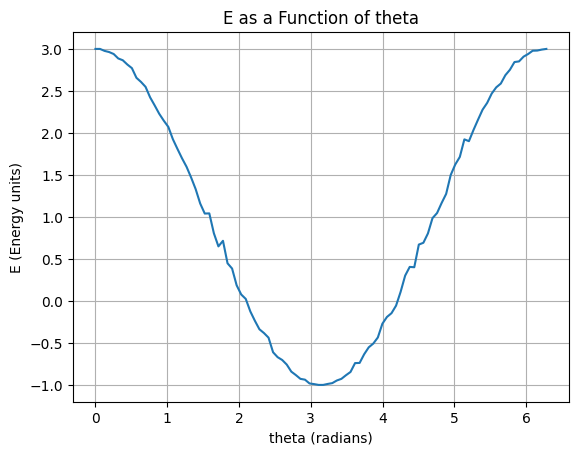

In [54]:
import matplotlib.pyplot as plt

# Extract values of E and t
E_values = [np.real(E.value) for E in batch_estimate_result]
theta_values = [sample["t"] for sample in batch_sample]

# Plot E as a function of t
plt.plot(theta_list, E_values)
plt.xlabel("theta (radians)")
plt.ylabel("E (Energy units)")
plt.title("E as a Function of theta")
plt.grid(True)  # Add grid for better visualization
plt.show()

In [55]:
print("The number of different energies:", len(E_values))
print("The minimal energy is:", min(E_values))

The number of different energies: 100
The minimal energy is: -0.998046875


Using `.submit_estimate()` and `submit_batch_estimate()` is useful for long executions and real hardware execution, allowing results to be retrieved later using the job's `id` for single or multiple sets of execution parameters, respectively.

<details>
<summary>Practice</summary>

**Fundamental Practice:**

Verify your understanding by repeating what was done in the **Sample** section but using `.submit_estimate()` and `submit_batch_estimate()`.

**Advanced Practice:**

Use one of the `estimate` options to implement the [VQE](https://docs.classiq.io/latest/user-guide/read/qml_with_classiq_guide/#using-the-vqe-primitive) algorithm yourself.

</details>

## Read More

- User Guide:
    - [`ExecutionSession`]((https://docs.classiq.io/latest/user-guide/executor/ExecutionSession/))
    - [`ExecutionJob`](https://docs.classiq.io/latest/sdk-reference/#classiq.execution.jobs.ExecutionJob)
- Examples:
    - [Hamiltomian Simulation](https://docs.classiq.io/latest/user-guide/read/hamiltonian_simulation_guide/)
    - [Variational Quantum Linear Solver (VQLS)](https://docs.classiq.io/latest/explore/algorithms/vqls/lcu_vqls/vqls_with_lcu/?h=vql)